In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!kaggle datasets download -d valentynsichkar/traffic-signs-preprocessed

Dataset URL: https://www.kaggle.com/datasets/valentynsichkar/traffic-signs-preprocessed
License(s): other
100% 4.16G/4.16G [00:50<00:00, 92.6MB/s]
100% 4.16G/4.16G [00:50<00:00, 88.7MB/s]


In [5]:
!pip install keras

In [6]:
!pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56437 sha256=ee2fccde613c994c154557af834eaeec3a7b84c1a578df284260d11634a2435a
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [7]:
!unzip \*.zip

Archive:  traffic-signs-preprocessed.zip
  inflating: data0.pickle            
  inflating: data1.pickle            
  inflating: data2.pickle            
  inflating: data3.pickle            
  inflating: data4.pickle            
  inflating: data5.pickle            
  inflating: data6.pickle            
  inflating: data7.pickle            
  inflating: data8.pickle            
  inflating: datasets_preparing.py   
  inflating: label_names.csv         
  inflating: labels.pickle           
  inflating: mean_image_gray.pickle  
  inflating: mean_image_rgb.pickle   
  inflating: std_gray.pickle         
  inflating: std_rgb.pickle          
  inflating: test.pickle             
  inflating: train.pickle            
  inflating: valid.pickle            


In [8]:

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from timeit import default_timer as timer

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Input, Add, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau


In [9]:
# Function to convert labels to categorical
def to_categorical(y, num_classes=None):
    y = np.array(y, dtype='int')
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes))
    categorical[np.arange(n), y] = 1
    return categorical


In [10]:
# Load and preprocess data
with open('/content/data2.pickle', 'rb') as f:
    data = pickle.load(f, encoding='latin1')

data['y_train'] = to_categorical(data['y_train'], num_classes=43)
data['y_validation'] = to_categorical(data['y_validation'], num_classes=43)
data['x_train'] = data['x_train'].transpose(0, 2, 3, 1)
data['x_validation'] = data['x_validation'].transpose(0, 2, 3, 1)
data['x_test'] = data['x_test'].transpose(0, 2, 3, 1)


In [11]:
# Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=False,
    vertical_flip=False

)
datagen.fit(data['x_train'])


In [12]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Add, GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D

def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = Conv2D(filters, kernel_size, strides=stride, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)

    x = Add()([x, shortcut])
    x = tf.keras.activations.relu(x)  # Replace tf.nn.relu with Keras equivalent
    return x

In [13]:
# Model
inputs = Input(shape=(32, 32, 3))

x = Conv2D(32, kernel_size=3, padding='same')(inputs)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(64, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(128, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D(pool_size=2)(x)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(43, activation='softmax')(x)
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Learning rate and early stopping callbacks
annealer = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True)


In [28]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Define the Learning Rate Scheduler
annealer = LearningRateScheduler(lambda epoch: 1e-3 * 0.95 ** epoch)
epochs = 30
n_images = 12000

# Train the model using a subset of data without data augmentation
h = model.fit(
    data['x_train'][:n_images],
    data['y_train'][:n_images],
    batch_size=64,
    epochs=epochs,
    validation_data=(data['x_validation'], data['y_validation']),
    callbacks=[annealer],
    verbose=2
)

Epoch 1/30
188/188 - 47s - 252ms/step - accuracy: 0.9154 - loss: 0.2883 - val_accuracy: 0.7821 - val_loss: 0.7684 - learning_rate: 0.0010
Epoch 2/30
188/188 - 82s - 435ms/step - accuracy: 0.9323 - loss: 0.2338 - val_accuracy: 0.8136 - val_loss: 0.7073 - learning_rate: 9.5000e-04
Epoch 3/30
188/188 - 82s - 436ms/step - accuracy: 0.9430 - loss: 0.2006 - val_accuracy: 0.8726 - val_loss: 0.4272 - learning_rate: 9.0250e-04
Epoch 4/30
188/188 - 81s - 433ms/step - accuracy: 0.9441 - loss: 0.1999 - val_accuracy: 0.8361 - val_loss: 0.5898 - learning_rate: 8.5737e-04
Epoch 5/30
188/188 - 45s - 238ms/step - accuracy: 0.9493 - loss: 0.1825 - val_accuracy: 0.9102 - val_loss: 0.3183 - learning_rate: 8.1451e-04
Epoch 6/30
188/188 - 46s - 244ms/step - accuracy: 0.9528 - loss: 0.1715 - val_accuracy: 0.9120 - val_loss: 0.3350 - learning_rate: 7.7378e-04
Epoch 7/30
188/188 - 82s - 434ms/step - accuracy: 0.9593 - loss: 0.1555 - val_accuracy: 0.8907 - val_loss: 0.4127 - learning_rate: 7.3509e-04
Epoch 8/30

In [29]:
# Evaluate Model
print('Epochs={0:d}, training accuracy={1:.5f}, validation accuracy={2:.5f}'.\
      format(epochs, max(h.history['accuracy']), max(h.history['val_accuracy'])))


Epochs=30, training accuracy=0.98250, validation accuracy=0.93673


In [30]:
# Testing the model
y_test_true = data['y_test']

predictions = model.predict(data['x_test'])
predictions = np.argmax(predictions, axis=1)

accuracy = np.mean(predictions == y_test_true)
print(f'testing accuracy = {accuracy:.4f}')



395/395 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step
testing accuracy = 0.9162


In [32]:
!pip install gtts

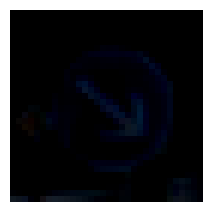

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
ClassId: 38
Label: Keep right


In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gtts import gTTS
import os
import IPython.display as ipd

# Example Prediction
imageID = 1025

x_input = data['x_test'][imageID:imageID+1]
y_input = data['y_test'][imageID:imageID+1]

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.imshow(x_input[0, :, :, :])
plt.axis('off')
plt.show()

scores = model.predict(x_input)
prediction = np.argmax(scores)
print('ClassId:', prediction)

def label_text(file):
    label_list = []
    r = pd.read_csv(file)
    for name in r['SignName']:
        label_list.append(name)
    return label_list

labels = label_text('/content/label_names.csv')
predicted_label = labels[prediction]
print('Label:', predicted_label)

# Convert the label to speech
tts = gTTS(text=predicted_label, lang='en')
audio_file = "/content/predicted_label.mp3"
tts.save(audio_file)

# Play the audio
ipd.display(ipd.Audio(audio_file, autoplay=True))
